# Figures for the Report and Presentation



Primarily from the [NOIRLab API examples](https://github.com/NOAO/nat-nb/blob/master/sia.ipynb)

In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.utils import data as data_utils
#from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
import astropy.coordinates as coord
import astropy.units as u

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

# import json
# import requests
from dl import authClient as ac, queryClient as qc
import pandas as pd

## FIGURE 1: Sky Coverage (Overlay the 2.3m sky coverage with the DR10 Legacy Survey)

Query All Bricks From the LS_DR10 Bricks_s Auxiliary Table

In [3]:
query = f""" 
        SELECT brickname, ra,dec
        FROM ls_dr10.bricks_s
        WHERE nexp_g >= 1
        """
all_bricks= qc.query(sql=query,fmt="pandas")

Query All Bricks with No observations in the g Filter

In [4]:
# get all the brick names and ra/dec of every brick with NO observations in the g filter

query = f"""
        SELECT brickname, ra, ra1, ra2, dec, dec1, dec2, nexp_g, nexp_i, nexp_r, nexp_z, wise_nobs_1, wise_nobs_2, wise_nobs_3, wise_nobs_4
        FROM ls_dr10.bricks_s
        WHERE nexp_g<1
        """

non_g_bricks = qc.query(sql=query, fmt="pandas")


In [5]:
# bricks with r band observations
r_bricks = non_g_bricks[non_g_bricks['nexp_r']!=0]
# no r band, but i band
i_bricks = non_g_bricks[(non_g_bricks['nexp_r']==0) & (non_g_bricks['nexp_i']!=0)]
# no r or i bands, but z band
z_bricks = non_g_bricks[(non_g_bricks['nexp_r']==0) & (non_g_bricks['nexp_i']==0) & (non_g_bricks['nexp_z']!=0)]
# no r, i, or z
wise_only = non_g_bricks[(non_g_bricks['nexp_r']==0) & (non_g_bricks['nexp_i']==0) & (non_g_bricks['nexp_z']==0)]

Almost all of the DR10 bricks have at least one g-band observation associated with them, and those that don't are mostly along the edge of the Milky Way plane and the Magellanic Clouds. Out of the ~16k bricks that aren't accounted for in the g-band, only about 2900 only have WISE (W1, W2, W3, W4) observations that would require different calibration and image processing to handle.

## Previous Figure 1

Option 1

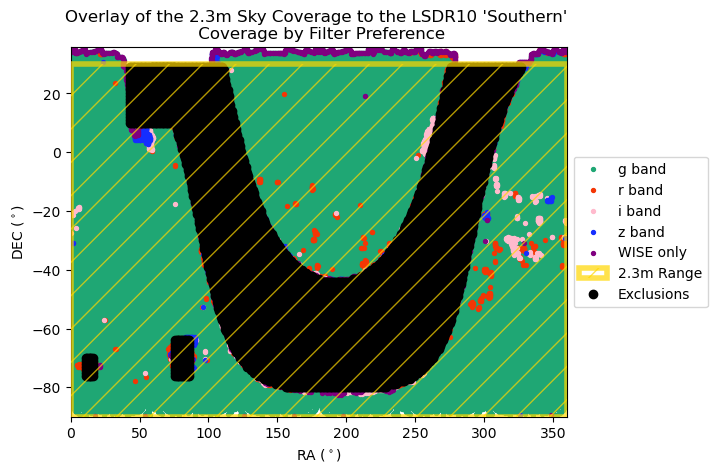

In [85]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1,1)
ax.scatter(all_bricks['ra'], all_bricks['dec'],s=8, c='xkcd:jade') #label="g band")
# ax.plot(non_g_bricks['ra'], non_g_bricks['dec'], 'b.', label="non g band")
ax.scatter(r_bricks['ra'], r_bricks['dec'], s=8, c='xkcd:orangish red') #label="r band")
ax.scatter(i_bricks['ra'], i_bricks['dec'], s=8, c='xkcd:pastel pink')# label="i band")
ax.scatter(z_bricks['ra'], z_bricks['dec'], s=8, c='xkcd:vivid blue') #label="z band")
ax.scatter(wise_only['ra'], wise_only['dec'], s=8,  c='purple')#label="WISE only")
#fig.patches.extend([plt.Rectangle((0,-90),360,120,facecolor='y',alpha=0.3,hatch='/',linewidth=2,transform=fig.transFigure, figure=fig)])
plt.gca().add_patch(Rectangle((0,-90),360,120,
                                  fill=False, hatch='/', alpha=0.7, edgecolor='gold',linewidth=4, zorder=100,
                                figure=fig)) #label="2.3m Range"))
ax.set(title="Overlay of the 2.3m Sky Coverage to the LSDR10 'Southern' \n Coverage by Filter Preference", xlabel="RA ($^\circ$)", ylabel="DEC ($^\circ$)")
#Highlighting the exclusion of the galactic plane |b|<18
for ra_b in range(10,330):
    for dec_b in range(-80,30):
      coord_radec=SkyCoord(ra=ra_b, dec=dec_b, frame='icrs', unit='degree')
      coord_gal=coord_radec.galactic
      if abs(coord_gal.b.value)<=19:
        ax.plot(ra_b,dec_b,'ko') #label='Exclusions')
      # Highlight LMC
      if (ra_b >=76) and (ra_b <= 86) and (dec_b >= -76) and (dec_b <= -64):
        ax.plot(ra_b,dec_b,'ko')
      # Highlight SMC
      if (ra_b >=11) and (ra_b <= 16) and (dec_b >= -76) and (dec_b <= -70):
        ax.plot(ra_b,dec_b,'ko')
      #Exclude the gap near the galactic plane
      if (ra_b >=43) and (ra_b <= 75) and (dec_b >= 10) and (dec_b <= 30):
        ax.plot(ra_b,dec_b,'ko')
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(['g band', 'r band','i band','z band', 'WISE only','2.3m Range', 'Exclusions'],loc='center left', bbox_to_anchor=(1, 0.5))
ax.margins(x=0,y=0)
plt.show()

Aitoff Projection

Text(0, 0.5, 'Dec[deg]')

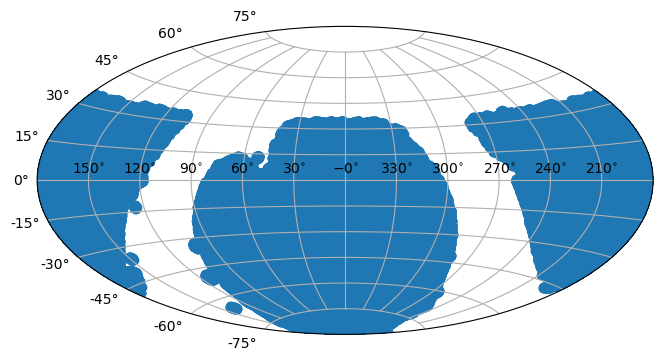

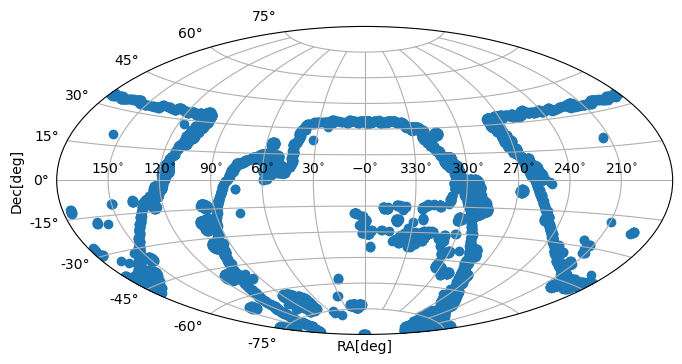

In [9]:
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
import astropy.coordinates as coord
import astropy.units as u
g_band=SkyCoord(ra=all_bricks["ra"],dec=all_bricks["dec"],frame='icrs',unit=u.degree)
non_g_band=SkyCoord(ra=non_g_bricks["ra"],dec=non_g_bricks["dec"],frame='icrs',unit=u.degree)
def coordinates_aitoff_plot(coords):
    fig, ax = plt.subplots(figsize=(10, 4), 
                           subplot_kw=dict(projection="aitoff"))
    
    sph = coords.spherical
    cs = ax.scatter(-sph.lon.wrap_at(180*u.deg).radian,
                    sph.lat.radian)

    def fmt_func(x, pos):
        val = coord.Angle(-x*u.radian).wrap_at(360*u.deg).degree
        return f'${val:.0f}' + r'^{\circ}$'

    ticker = mpl.ticker.FuncFormatter(fmt_func)
    ax.xaxis.set_major_formatter(ticker)

    ax.grid()
    
    return fig, ax
fig,ax=coordinates_aitoff_plot(g_band)
fig,ax=coordinates_aitoff_plot(non_g_band)

ax.set_xlabel('RA[deg]')
ax.set_ylabel('Dec[deg]')

## FINAL Aitoff Projection

<function matplotlib.pyplot.show(close=None, block=None)>

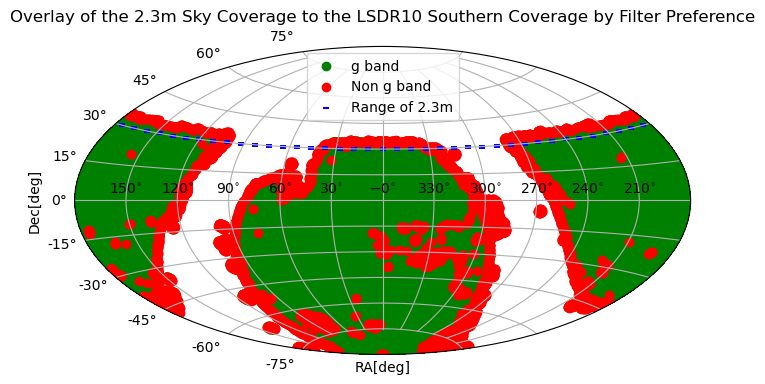

In [19]:
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
import astropy.coordinates as coord
import astropy.units as u
g_band=SkyCoord(ra=all_bricks["ra"],dec=all_bricks["dec"],frame='icrs',unit=u.degree)
non_g_band=SkyCoord(ra=non_g_bricks["ra"],dec=non_g_bricks["dec"],frame='icrs',unit=u.degree)
range_23=SkyCoord(ra=np.linspace(0,360,40),dec=np.array(40*[30]),frame='icrs',unit=u.degree)
#Reference:'https://learn.astropy.org/tutorials/2-Coordinates-Transforms#Coordinate-Representations'
fig, ax = plt.subplots(figsize=(10, 4), 
        subplot_kw=dict(projection="aitoff"))
sph = g_band.spherical
cs = ax.scatter(-sph.lon.wrap_at(180*u.deg).radian,
                sph.lat.radian, color='g', label="g band")
def fmt_func(x, pos):
        val = coord.Angle(-x*u.radian).wrap_at(360*u.deg).degree
        return f'${val:.0f}' + r'^{\circ}$'
ticker = mpl.ticker.FuncFormatter(fmt_func)
ax.xaxis.set_major_formatter(ticker)
sph1 = non_g_band.spherical
cs1 = ax.scatter(-sph1.lon.wrap_at(180*u.deg).radian,
                sph1.lat.radian,color='r', label="Non g band")
sph2=range_23.spherical
cs2=ax.scatter(-sph2.lon.wrap_at(180*u.deg).radian,
                sph2.lat.radian,color='b',marker='_',s=15, label="Range of 2.3m")
#print(sph1.lat.degree)
#print(sph1.lon.radian)
plt.title(label='Overlay of the 2.3m Sky Coverage to the LSDR10 Southern Coverage by Filter Preference', fontweight=10, pad='18.0')
ax.set_xlabel('RA[deg]')
ax.set_ylabel('Dec[deg]')
ax.legend()
ax.grid()
#plt.fill_between(30, -90, color='y',aplha=0.5)
#point1=[180,30]
#p1=point1.spherical
#point2=[270,30]
#p2=point2.spherical
#plt.plot(point1,'k')
#wedge=Wedge((30, 10), 21, 180, 360, width=12, color='y',alpha=0.3)
#ax.add_artist(wedge)
#plt.gca().add_patch(Rectangle((0*u.deg,0*u.deg),300*u.deg,100*u.deg,
                                #fill=True,facecolor='y',hatch='/', alpha=0.3, edgecolor='orange',linewidth=2, zorder=100,
                                #figure=fig, label="2.3m Range"))
plt.show
    

## FIGURE 2: Electromagnetic Range of the 2.3m to the DES Filters

In [50]:
path_string ="C:\\Users\\afalv\\Downloads\\STD_BANDPASSES_DR1.fits"
hdu = fits.open(path_string, memmap=True)
hdu.info()
file_header = hdu[1].header
file_data = hdu[1].data
print(repr(file_header))


Filename: C:\Users\afalv\Downloads\STD_BANDPASSES_DR1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     22   1441R x 7C   [D, D, D, D, D, D, E]   
XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   52 / length of dimension 1                          
NAXIS2  =                 1441 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'LAMBDA  '                                                            
TFORM1  = 'D       

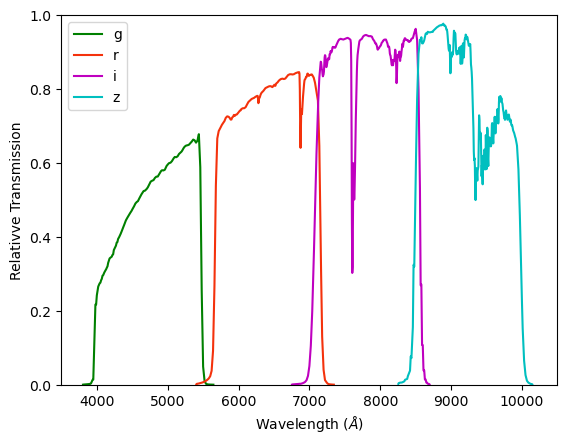

In [91]:
x=file_data['LAMBDA']
g=file_data['g']
r=file_data['r']
I=file_data['i']
z=file_data['z']
empty_g=[]
x_g=[]
for i in range(0,len(g)):
    if g[i]>0:
        empty_g.append(g[i])
        x_g.append(x[i])

empty_r=[]
x_r=[]
for i in range(0,len(r)):
    if r[i]>0:
        empty_r.append(r[i])
        x_r.append(x[i])

empty_i=[]
x_i=[]
for i in range(0,len(I)):
    if I[i]>0:
        empty_i.append(I[i])
        x_i.append(x[i])

empty_z=[]
x_z=[]
for i in range(0,len(z)):
    if z[i]>0:
        empty_z.append(z[i])
        x_z.append(x[i])

plt.plot(x_g,empty_g, color='g', label='g')
plt.plot(x_r,empty_r, color='xkcd:vermillion', label='r')
plt.plot(x_i,empty_i, color='m', label='i')
plt.plot(x_z,empty_z,color='c', label='z')
#plt.title('Wavelength Ranges and Relative Transmission for the DECam Filters')
plt.ylim([0,1])
plt.xlim([3500,10500])
plt.legend()
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Relativve Transmission')
plt.margins(x=0, y=0)
plt.show()

#Wifes is 320-980nm
#g_band is 398-548nm
#r_band is 568-716
#i-band is 710-857
#z-band is 850-1002

## Check Tractor

In [4]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.coordinates import SkyCoord

import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

from dl import queryClient as qc
import pandas as pd
from sklearn.neighbors import KDTree

 # Bounds of the square we are querying objects for
ra=3
dec=-4
dist=1
ra_min=ra
ra_max = ra + dist
dec_min=dec
dec_max = dec + dist


In [ ]:
query = f"""
    SELECT ra, dec, mag_g,mag_r,mag_i,mag_z,fracin_g
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_g<=21 AND mag_g>=16
    """
brick_info = qc.query(sql=query, fmt="pandas")
brick_info

 
query1 = f"""
    SELECT ra, dec, mag_g,mag_r,mag_i,mag_z, fracin_r
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_r<=21 AND mag_r>=16
    """
brick_info1 = qc.query(sql=query1, fmt="pandas")
brick_info1


query2 = f"""
    SELECT ra, dec, mag_g,mag_r,mag_i,mag_z, fracin_i
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_i<=21 AND mag_i>=16
"""
brick_info2 = qc.query(sql=query2, fmt="pandas")
brick_info2

        
query3 = f"""
    SELECT ra, dec, mag_g,mag_r,mag_i,mag_z, fracin_z
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_z<=21 AND mag_z>=16
    """
brick_info3 = qc.query(sql=query3, fmt="pandas")
brick_info3





In [5]:
 # Bounds of the square we are querying objects for
query = f"""
    SELECT ra, dec
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_g<=21 AND mag_g>=16
    """
brick_info4 = qc.query(sql=query, fmt="pandas")
brick_info4.to_csv('g.csv')

 
query1 = f"""
    SELECT ra, dec
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_r<=21 AND mag_r>=16
    """
brick_info5 = qc.query(sql=query1, fmt="pandas")
brick_info5.to_csv('r.csv')

query2 = f"""
    SELECT ra, dec
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_i<=21 AND mag_i>=16
"""
brick_info6 = qc.query(sql=query2, fmt="pandas")
brick_info6.to_csv('i.csv')

        
query3 = f"""
    SELECT ra, dec
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND mag_z<=21 AND mag_z>=16
    """
brick_info3 = qc.query(sql=query3, fmt="pandas")
brick_info3.to_csv('z.csv')



[Text(0.5, 1.0, 'Histogram of fracin_z'), Text(0.5, 0, 'fracin_z')]

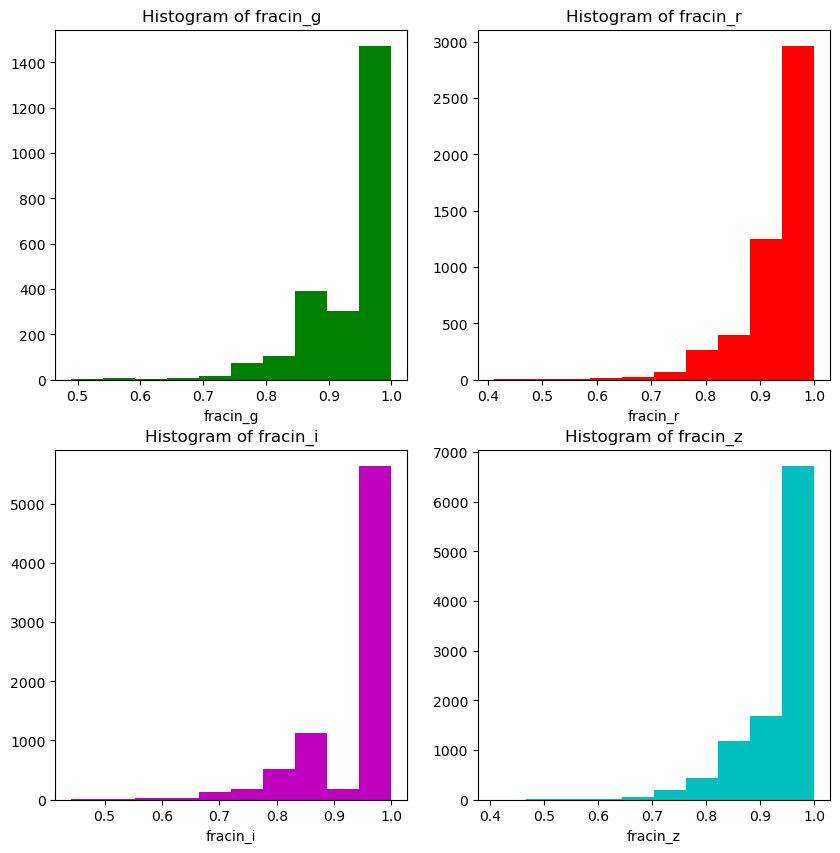

In [91]:
fig,ax1 = plt.subplots(2, 2, figsize=[10,10])
ax1[0,0].hist(brick_info['fracin_g'], color='g')
ax1[0,0].set(title='Histogram of fracin_g', xlabel='fracin_g')
ax1[0,1].hist(brick_info1['fracin_r'], color='r')
ax1[0,1].set(title='Histogram of fracin_r', xlabel='fracin_r')
ax1[1,0].hist(brick_info2['fracin_i'], color='m')
ax1[1,0].set(title='Histogram of fracin_i', xlabel='fracin_i')
ax1[1,1].hist(brick_info3['fracin_z'], color='c')
ax1[1,1].set(title='Histogram of fracin_z', xlabel='fracin_z')


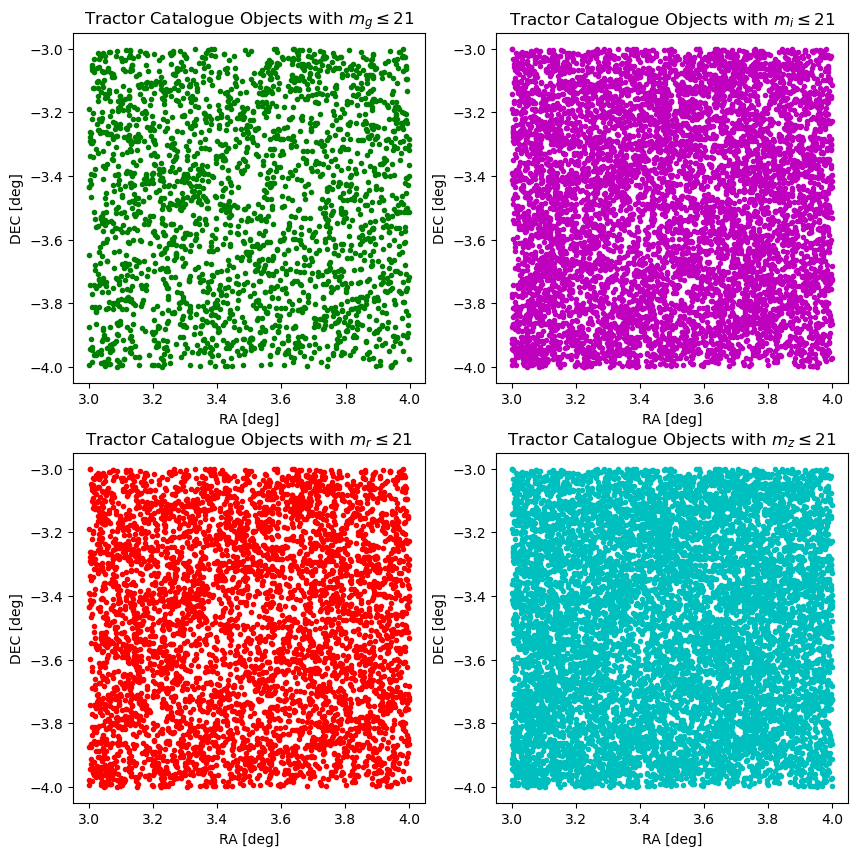

In [78]:
fig,ax = plt.subplots(2, 2, figsize=[10,10])
ax[0,0].plot(brick_info['ra'],brick_info['dec'],'g.')
ax[0,0].set(title='Tractor Catalogue Objects with ${m_g}\leq21$', xlabel='RA [deg]', ylabel='DEC [deg]')

ax[1,0].plot(brick_info1['ra'],brick_info1['dec'],'r.')
ax[1,0].set(title='Tractor Catalogue Objects with ${m_r}\leq21$', xlabel='RA [deg]', ylabel='DEC [deg]')

ax[0,1].plot(brick_info2['ra'],brick_info2['dec'],'m.')
ax[0,1].set(title='Tractor Catalogue Objects with ${m_i}\leq21$', xlabel='RA [deg]', ylabel='DEC [deg]')

ax[1,1].plot(brick_info3['ra'],brick_info3['dec'],'c.')
ax[1,1].set(title='Tractor Catalogue Objects with ${m_z}\leq21$', xlabel='RA [deg]', ylabel='DEC [deg]')

plt.show()

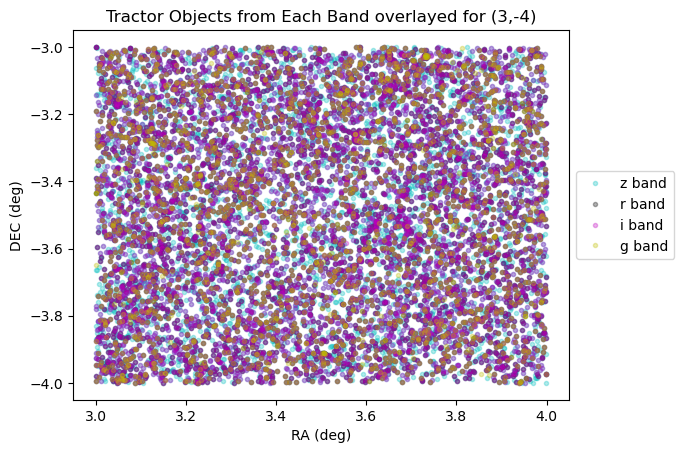

In [79]:
plt.plot(brick_info3['ra'],brick_info3['dec'],'c.', label='z band', alpha=0.3)
plt.plot(brick_info1['ra'],brick_info1['dec'],'k.', label='r band', alpha=0.3)
plt.plot(brick_info2['ra'],brick_info2['dec'],'m.', label='i band', alpha=0.3)
plt.plot(brick_info['ra'],brick_info['dec'],'y.', label='g band',alpha=0.3)
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.title('Tractor Objects from Each Band overlayed for (3,-4)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## FIGURE 3: Plot that Compares SE Findings to Tractor Objects in that Area

Going to use a 0.25*0.25 Brick (0001m002)

Getting Image of Brick from Legacy Survey

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from scipy.ndimage import distance_transform_edt
from astropy.visualization import (MinMaxInterval, ImageNormalize)
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.utils import data as data_utils
from astropy.coordinates import SkyCoord
from astropy.nddata import bitmask

import sep
sep.set_extract_pixstack(1000000)

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np
from dl import authClient as ac, queryClient as qc
import pandas as pd

In [9]:
def obtain_image(brick, filter="g", reset_cache=True, return_bitmask=False):
    """Returns the header and data for a coadded FITS file queried from the Legacy Survey DR10 portal
    
    Files are accessed with a url pattern of `<section>/<brick>/legacysurvey-<brick>-image-<filter>.fits.fz`
    as documented on the [Legacy Survey website](https://www.legacysurvey.org/dr10/files/#image-stacks-south-coadd).
    Images can be deleted from cache after the header and data are extracted.
    
    Parameters
    ----------
    brick:  `str`
        Brick name of image: RRRr(p/m)DDd
    filter: `str`
        Photographic filter of image to request (g, r, i, z)
    reset_cache: `bool`, default `True`
        Clears the downloaded image from the cache
    return_bitmask: `bool`, default `True`
        Downloads and returns corresponding bitmask associated with image stack
        
    Returns
    -------
    header: `CompImageHeader`
        Astropy object of the FITS header data
    data: `ndarray`
        Numpy NDarray of FITS image data
    bitmask_header: `CompImageHeader`
        (Optional, `return_bitmask=True`) Astropy object of the bitmask header data
    bitmask_data: `ndarray`
        (Optional, `return_bitmask=True`) Numpy NDarray of bitmask data
    """
    
    url = "https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/south/coadd/"
    image_string = url + f"{brick[0:3]}/{brick}/legacysurvey-{brick}-image-{filter}.fits.fz"
    bitmask_string = url + f"{brick[0:3]}/{brick}/legacysurvey-{brick}-maskbits.fits.fz"
    
    
    print(f"Downloading Image: {image_string}....")

    # assumes only one image, in the first non-primary header file
    with fits.open(image_string) as hdu:
        img_header = hdu[1].header
        img_data = hdu[1].data
    
    # download corresponding MASKBITS bitmask as well
    if return_bitmask:
        print(f"Downloading Bitmask: {bitmask_string}....")
        with fits.open(bitmask_string) as hdu:
            # print(hdu.info())
            # bitmask = hdu
            bitmask_header = hdu[1].header
            bitmask_data = hdu[1].data
    
    if reset_cache:
        print("Clearing download cache...")
        data_utils.clear_download_cache(image_string)
        data_utils.clear_download_cache(bitmask_string)
    
    if return_bitmask:
        return img_header, img_data, bitmask_header, bitmask_data
    
    return img_header, img_data

header, data, bitmask_header, bitmask_data = obtain_image("0001m002", "g", reset_cache=False, return_bitmask=True)

In [12]:
def query_psf():
    query = f"""
    SELECT psfsize_g
    FROM ls_dr10.bricks_s
    WHERE brickid = ({header['BRICKID']})
    """

    brick_psf = qc.query(sql=query, fmt="pandas")

    return brick_psf['psfsize_g'][0]

psf_size = query_psf()

In [13]:
def thresh_values(mag_limit=21, pixscale=0.262):
    """Pull out the three relevant values for calculating threshold required for source extraction. Uses SEP for background subtraction.

    The average background of the image can be taken as a single number average, or an array by pixel. Here, we have taken a single number average for simplicity.
    
    Parameters
    ----------
    mag_limit : `float`, optional
        Limiting magnitude of instrument, after which point objects will not be detected. Default is 21, the limit of the ANU 2.3m telescope.

    Returns
    -------
    sigma_gb : `float`
        Global RMS of the image background
    mag_zero : `float'
        Astropy object of the FITS header data, contains zero point of image
    mag_limit : `int`
        Limiting magnitude of instrument
    """

    # single number background average
    bkg = sep.Background(data)
    sigma_gb = bkg.globalrms

    # zero point
    mag_zero = header['MAGZERO']

    # median psf in pixels
    median_psf = float(psf_size) / pixscale

    return (sigma_gb, mag_zero, mag_limit, median_psf)

In [14]:
def threshold_func():
    """ Function to calculate threshold for SEP.

    Returns
    -------
    threshold :  `float`
        Value calculated from background, zero point and limiting magnitude for the threshold for object detection
    """

    sigma_gb, mag_zero, mag_limit, median_psf = thresh_values()
    threshold = (1 / sigma_gb) * (1 / median_psf) * (10 ** ((mag_zero -  mag_limit) / 2.5))
    return threshold
thresh = threshold_func()
print("Threshold: ", thresh)

Threshold:  387.78062200210763


In [15]:
def source_exctract():
    objects = sep.extract(data, thresh, err=sep.Background(data).globalrms, segmentation_map=True)
    bkg_img = objects[0]
    seg_map = objects[1] # the boolean array of light/dark spots is what we need to create the segmentation map.

    return (bkg_img, seg_map)

bkg_image, seg_map = source_exctract()
len(bkg_image)

50

In [16]:
query = f"""
    SELECT ra,dec
    FROM ls_dr10.tractor_s
    WHERE ra >= (0) AND ra < (0.5)
    AND dec >= (-4) AND dec < (0)
    AND mag_g > 0 AND brickname='0001m002' AND mag_g<=21
    """
tractor_objs=qc.query(sql=query,fmt="pandas")
tractor_objs

,ra,dec
0,0.026918,-0.364865
1,0.013281,-0.360080
2,0.037058,-0.357003
3,0.047731,-0.361495
4,0.048685,-0.360492
...,...,...
156,0.200938,-0.132477
157,0.239152,-0.211355
158,0.247303,-0.211306
159,0.232754,-0.178004


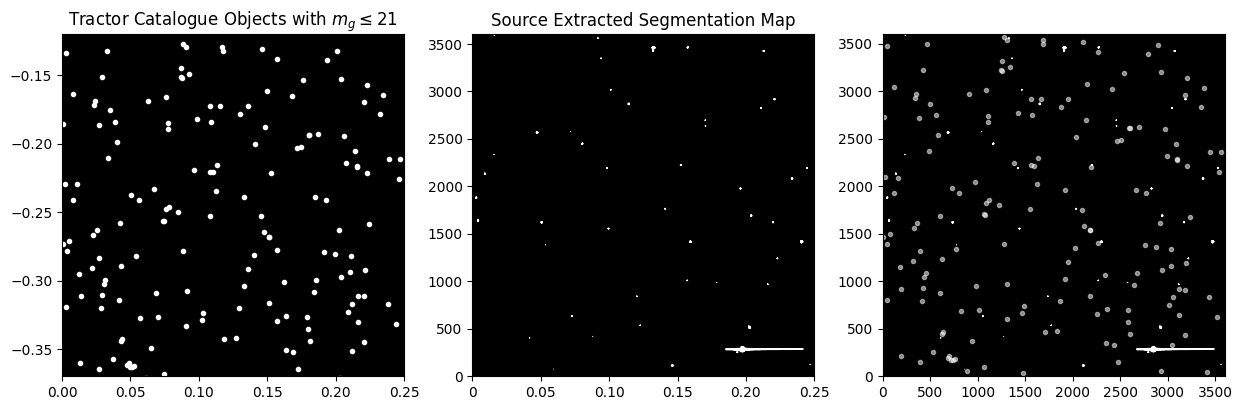

In [73]:
fig, ax = plt.subplots(1, 3, figsize=[15,5])

ax[0].set_facecolor('k')
ax[0].plot(tractor_objs['ra'],tractor_objs['dec'],'w.')
ax[0].set(title='Tractor Catalogue Objects with ${m_g}\leq21$')
ax[0].set_aspect('equal')
ax[0].set_xlim(0,0.25)
ax[0].set_ylim(-0.37,-0.12)

ax[1].imshow(seg_map, origin='lower', cmap='gray', vmin=0, vmax=1)
ax[1].set_xticks([0,720,1440,2160,2880,3600])
ax[1].set_xticklabels(['0','0.05','0.10','0.15','0.20','0.25'])
#ax[1].tick_params(labelleft=False, left=False)
ax[1].set(title="Source Extracted Segmentation Map")

implot = ax[2].imshow(seg_map, origin='lower', cmap='gray', vmin=0, vmax=1)
ax[2].set_facecolor('k')
ax[2].plot(tractor_objs['ra']*14400,tractor_objs['dec']*14400+5400,'w.',alpha=0.5)
ax[2].set_aspect('equal')
plt.show()

## FIGURE 4: Histogram of Mask Radius

## FIGURE 5: 0.25*0.25 Grid of SEG Map and Dark Sky Identification

In [9]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits

import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

from dl import queryClient as qc
import pandas as pd
from scipy.spatial import distance_matrix

Querying the catalogue for 0.25 degree squares

In [25]:
def query_tractor(ra, dec, dist=1.0):
    """Queries the Astro Data Lab for the ra, dec and mag_g of the objects within a square of side length (dist).     
    dist is in degrees
    """
    # Bounds of the square we are querying objects for
    ra_min=ra
    ra_max = ra + dist
    dec_min=dec
    dec_max = dec + dist
    
    query = f"""
            SELECT ra, dec, mag_g,mag_r,mag_i,mag_z
            FROM ls_dr10.tractor_s
            WHERE ra >= ({ra_min}) AND ra < ({ra_max})
            AND dec >= ({dec_min}) AND dec < ({dec_max})
            AND (mag_g<=21 AND mag_g>=16
              OR mag_r<=21 AND mag_r>=16
               OR mag_i<=21 AND mag_i>=16
               OR mag_z<=21 AND mag_z>=16)       
            """
    
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    return brick_info

Get Bitmask Info

In [38]:
def load_mask_data(index=0, load_all=False):
    """Load a desired mask data file by index, or just download all five. 
    Returns a pandas Dataframe with columns 'ra', 'dec', 'radius'
    """
    
    # load all
    if load_all:
        all_masks = []
        for i in range(5):
            
            with np.load(f"mask_data_files\mask_data_{i}.npz", mmap_mode='r') as mask_data:
                mask_array = mask_data['arr_0']
                mask_array_byteswap = mask_array.byteswap().newbyteorder()
                masked_stars = pd.DataFrame(mask_array_byteswap)
                all_masks.append(masked_stars)
        return pd.concat(all_masks, ignore_index=True)

    # load single index
    with np.load(f"mask_data_files\mask_data_{index}.npz", mmap_mode='r') as mask_data:
        mask_array = mask_data['arr_0']
        mask_array_byteswap = mask_array.byteswap().newbyteorder()
        masked_stars = pd.DataFrame(mask_array_byteswap)

    return masked_stars

Process Mask and Catalogue Data Together

In [39]:
def mask_radius(mag_g, mask_radius=20):
    return (mask_radius/3600) + 1630./3600. * 1.396**(-mag_g)

In [40]:
# combine mask and star data

def combine_data(masked_stars, catalog_stars, coords, mask_minimum):
    """Combines the data from masked and catalog stars based on some coordinate range"""
    # coords = [ra, ra+map_dist, dec, dec+map_dist]
    
    # cut masked stars to only use the same area as catalog_stars
    masked_box = masked_stars.query('(@coords[0] < ra < @coords[1]) and (@coords[2] < dec < @coords[3])')
    
    # apply buffer radius to mask and star data
    masked_box.loc[:, 'radius'] = masked_box['radius'] + (mask_minimum / 3600.)
    catalog_stars['radius'] = mask_radius(catalog_stars['mag_g'], mask_minimum)
    
    # remove g mag
    catalog_stars = catalog_stars.drop('mag_g', axis=1)
    
    # combine catalog + mask
    all_stars = pd.concat([masked_box, catalog_stars]).reset_index(drop=True)
    return all_stars

In [41]:
def create_pixel_columns(all_stars, coords, dim):
    """Creates columns for min and max ra and dec for all stars in the dataframe"""
    # coords: [ra, ra+map_dist, dec, dec+map_dist]
    
    # find max and min ra/dec corresponding to the mask of star
    all_stars['max_ra'] = all_stars['ra'] + all_stars['radius']
    all_stars['min_ra'] = all_stars['ra'] - all_stars['radius']
    all_stars['max_dec'] = all_stars['dec'] + all_stars['radius']
    all_stars['min_dec'] = all_stars['dec'] - all_stars['radius']
    
    # boolean for radii that go above 1-degree integer RA/DEC bounds
    expression = '(max_ra > ceil(ra)) | (min_ra < floor(ra)) | (max_dec > ceil(dec)) | (min_dec < floor(dec))'
    all_stars['overlap'] = all_stars.eval(expression)
    
    # ra, dec, and radius in pixels
    # TODO check if off by one is needed?
    all_stars['ra_pix'] = np.round((all_stars['ra'] - coords[0]) * dim).astype(int) - 1
    all_stars['dec_pix'] = np.round((all_stars['dec'] - coords[2]) * dim).astype(int) - 1
    all_stars['rad_pix'] = np.ceil(all_stars['radius'] * dim).astype(int)
    
    all_stars['min_ra_pix'] = all_stars['ra_pix'] - all_stars['rad_pix']
    all_stars['max_ra_pix'] = all_stars['ra_pix'] + all_stars['rad_pix']
    all_stars['min_dec_pix'] = all_stars['dec_pix'] - all_stars['rad_pix']
    all_stars['max_dec_pix'] = all_stars['dec_pix'] + all_stars['rad_pix']
    
    # set stars outside of map range to that value
    all_stars.loc[all_stars['min_ra_pix'] < 0, 'min_ra_pix'] = 0
    all_stars.loc[all_stars['max_ra_pix'] > dim, 'max_ra_pix'] = dim
    all_stars.loc[all_stars['min_dec_pix'] < 0, 'min_dec_pix'] = 0
    all_stars.loc[all_stars['max_dec_pix'] > dim, 'max_dec_pix'] = dim
    
    return all_stars
    

Segementation Map

In [42]:
def seg_map(df:pd.DataFrame, dim):
    """Creates segementation map of shape (`dim`, `dim`) based on the mask locations and pixel data of `df`"""

    array = np.zeros((dim, dim), dtype=int)
    array.flatten()
    
    for star in df.to_dict('records'):
        
        # center pixel to determine distance from
        center = [[star['dec_pix'], star['ra_pix']]]
        
        # make array of indexes
        chunk = np.indices((star['max_dec_pix'] - star['min_dec_pix'], star['max_ra_pix'] - star['min_ra_pix']))
        
        # adjust indices to correspond to the larger grid
        # coord grid is shaped like [ [x1, y1], [x1, y2], ... [x1, yn], [x2, y1], ... [xn, yn] ]
        coord_grid = np.dstack((chunk[0]+star['min_dec_pix'], chunk[1]+star['min_ra_pix']))
        coord_grid = np.concatenate(coord_grid, axis=0)
        
        # calculate distances of each pixel coordinate to the center pixel
        distances = distance_matrix(x=coord_grid, y=center)

        # change all values of the segmap array to 0 where distances are < mask radius
        np.place(array[star['min_dec_pix']:star['max_dec_pix'], star['min_ra_pix']:star['max_ra_pix']], distances < star['rad_pix'], 1)

    array.reshape((dim, dim))
    return array

In [43]:
def define_grid(dim, fov=45):
    gridlines = np.arange(0, dim+1, (fov/3600 * dim))
    return gridlines

In [44]:
def find_dark_regions(array, gridlines):

    # calculating and storing the centre of each dark coord
    centers = []

    for i in range(len(gridlines[:-1])):
        centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

    x_cen, y_cen = np.meshgrid(centers, centers)

    dark_regions = []

    for i in range(len(gridlines) - 1):
        for j in range(len(gridlines) - 1):
            x_start, x_end = (gridlines[i]).astype(int), (gridlines[i + 1]).astype(int)
            y_start, y_end = (gridlines[j]).astype(int), (gridlines[j + 1]).astype(int)
            
            if np.all(array[y_start:y_end, x_start:x_end] == 0):
                dark_regions.append([x_cen[j, i], y_cen[j, i]])

    dr_trans = np.array(dark_regions).transpose()

    return dr_trans, dark_regions

In [45]:
def create_plot(array, coords, pix_coords, gridlines, dim, dr_trans):

    # Creating exclusion map with grid
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.imshow(array, origin = 'lower', cmap='gray', vmin=0, vmax=1)

    positions = np.linspace(0,dim,5)
    x_labels = np.linspace(coords[0],coords[1],5)
    y_labels = np.linspace(coords[2],coords[3],5)

    ax.set_xticks(positions, x_labels)
    ax.set_yticks(positions, y_labels)    

    plt.vlines(gridlines, min(pix_coords[1]), max(pix_coords[1]), color='red', linewidth=1)
    plt.hlines(gridlines, min(pix_coords[0]), max(pix_coords[0]), color= 'red', linewidth=1)

    plt.plot(dr_trans[0], dr_trans[1], 'rx', markersize=10)

    plt.tight_layout()
    plt.margins(0)
    plt.show()

    return

In [46]:
def create_data_frame(dark_regions, coords, dim):
    dark_ra = []
    dark_dec = []

    for i in dark_regions:
        ra = i[0] / (dim) + coords[0]
        dec = i[1] / (dim) + coords[2]
        dark_ra.append(ra)
        dark_dec.append(dec)

    dark_catalogue = pd.DataFrame({'ra':dark_ra, 'dec':dark_dec})
    return dark_catalogue

In [47]:
def generate_dark_sky_catalogue(ra, dec, query_dist=1.0, map_dist=1.0, mask_min_radius=20, fov=45, query_df=None, mask_df=None):
    """Generates a dataframe of RA/DEC pairs corresponding to allowed dark positions
    
    Parameters
    ----------
    ra: `float`
        starting right ascension to query/analyze from (degrees)
    dec: `float`
        starting declination to query/analyze from (degrees)
    query_dist: `float`
        length of one side of the queried square region of sky from starting ra/dec (degrees, default=1)
    map_dist: `float`
        length of one side of the analyzed square region of sky from starting ra/dec (degrees, default=1)
    mask_min_radius: `float`
        minimum masking radius for detected objects (arcseconds, default=20)
    fov: `float`
        minimum spacing between dark sky regions (arcseconds, default=45)
    """
    
    dim = int((3600*4) * map_dist)
    
    # load masked data
    print("Loading masked star data....")
    # masked_stars = load_mask_data(load_all=True)
    masked_stars = mask_df
    
    print(f"Querying the tractor catalog for stars from RA({ra}, {ra+query_dist}) to DEC({dec}, {dec+query_dist})...")
    tractor_df = query_df
    # tractor_df = query_tractor(ra, dec, query_dist)
    
    # concatenate data
    print("Combining mask and queried stars...")
    coords = [ra, ra+map_dist, dec, dec+map_dist]
    all_stars = combine_data(masked_stars, tractor_df, coords, mask_min_radius)

    # return
    print("Calculating pixel values for stars....")
    all_stars = create_pixel_columns(all_stars, coords, dim)

    print("Creating segmentation map...")
    array = seg_map(all_stars, dim, coords)

    print("Defining grid lines...")
    gridlines = define_grid(dim, fov)

    print("Finding dark regions...")
    dr_trans, dark_regions = find_dark_regions(array, gridlines)

    print("Plotting dark regions...")
    pix_coords = [all_stars['ra_pix'], all_stars['dec_pix'], all_stars['rad_pix']]
    create_plot(array, coords, pix_coords, gridlines, dim, dr_trans)

    print("Converting dark regions to coordinates...")
    dark_catalogue = create_data_frame(dark_regions, coords, dim)
    
    print("Done!")

    return dark_catalogue

In [48]:
query_df = query_tractor(3,-4, 1)
mask_df = load_mask_data(load_all=True)

In [53]:
#generate_dark_sky_catalogue(3,-4, query_df=query_df, mask_df=mask_df)
generate_dark_sky_catalogue(3,-4, query_df=query_df, mask_df=mask_df)

Loading masked star data....
Querying the tractor catalog for stars from RA(3, 4.0) to DEC(-4, -3.0)...
Combining mask and queried stars...
Calculating pixel values for stars....


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [266]:
# masking for low magnitude objects
def mask_radius(mag_g, mask_radius=20):
    return (mask_radius/3600) + 1630./3600. * 1.396**(-mag_g)

In [221]:
# masking for low magnitude objects

def mask_radius(tractor_df, fov_radius=20):
    radius = (fov_radius/3600) + 1630./3600. * 1.396**(-tractor_df['mag_g'])
    tractor_df['radius'] = radius
    return tractor_df

In [248]:
def load_mask_data(index=0, load_all=False):
    """Load a desired mask data file by index, or just download all five. 
    Returns a pandas Dataframe with columns 'ra', 'dec', 'radius'
    """
    
    # load all
    if load_all:
        all_masks = []
        for i in range(5):
            
            with np.load(f"mask_data_files\mask_data_{i}.npz", mmap_mode='r') as mask_data:
                mask_array = mask_data['arr_0']
                mask_array_byteswap = mask_array.byteswap().newbyteorder()
                masked_stars = pd.DataFrame(mask_array_byteswap)
                all_masks.append(masked_stars)
        return pd.concat(all_masks, ignore_index=True)

    # load single index
    with np.load(f"mask_data_files\mask_data_{index}.npz", mmap_mode='r') as mask_data:
        mask_array = mask_data['arr_0']
        mask_array_byteswap = mask_array.byteswap().newbyteorder()
        masked_stars = pd.DataFrame(mask_array_byteswap)

    return masked_stars

In [256]:
def full_df(masked_stars, tractor_df, coords):
    one_deg_sq = masked_stars.query(' (ra >' + str(coords[0]) + ') & (ra <' + str(coords[1]) + ') & (dec >' + str(coords[2]) + ') & (dec <' + str(coords[3]) + ')' )
    df = pd.concat([tractor_df,one_deg_sq], axis=0)
    df = df.drop('mag_g', axis=1)
    return df

In [257]:
def seg_map(df, dim, coords):

    array = np.zeros((dim, dim), dtype=int)

    ra_pix = np.round((df['ra'] - coords[0]) * dim).astype(int) - 1
    dec_pix = np.round((df['dec'] - coords[2]) * dim ).astype(int) - 1
    rad_pix = np.ceil(df['radius']*dim).astype(int)

    for y, x, r in zip(ra_pix,dec_pix,rad_pix):
        ra_max = x + r if x+r <= dim else dim
        ra_min = x - r if x-r >= 0 else 0
        dec_max = y + r if y+r <= dim else dim
        dec_min = y - r if y-r >= 0 else 0

        for i in range(ra_min,ra_max):
            for j in range(dec_min,dec_max):
                if ((i-x)**2 + (j-y)**2) <= r**2:
                    array[i,j] = 1

    return array, [ra_pix, dec_pix, rad_pix]

In [258]:
def define_grid(dim, fov=45):
    gridlines = np.arange(0, dim+1, (fov/3600 * dim))
    return gridlines

In [259]:
def find_dark_regions(array, gridlines):

    # calculating and storing the centre of each dark coord
    centers = []

    for i in range(len(gridlines[:-1])):
        centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

    x_cen, y_cen = np.meshgrid(centers, centers)

    dark_regions = []

    for i in range(len(gridlines) - 1):
        for j in range(len(gridlines) - 1):
            x_start, x_end = (gridlines[i]).astype(int), (gridlines[i + 1]).astype(int)
            y_start, y_end = (gridlines[j]).astype(int), (gridlines[j + 1]).astype(int)
            
            if np.all(array[y_start:y_end, x_start:x_end] == 0):
                dark_regions.append([x_cen[j, i], y_cen[j, i]])

    dr_trans = np.array(dark_regions).transpose()

    return dr_trans, dark_regions

In [260]:
def create_plot(array, coords, pix_coords, gridlines, dim, dr_trans):

    # Creating exclusion map with grid
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.imshow(array, origin = 'lower', cmap='gray', vmin=0, vmax=1)

    positions = np.linspace(0,dim,5)
    x_labels = np.linspace(coords[0],coords[1],5)
    y_labels = np.linspace(coords[2],coords[3],5)

    ax.set_xticks(positions, x_labels)
    ax.set_yticks(positions, y_labels)    

    plt.vlines(gridlines, min(pix_coords[1]), max(pix_coords[1]), color='red', linewidth=1)
    plt.hlines(gridlines, min(pix_coords[0]), max(pix_coords[0]), color= 'red', linewidth=1)

    plt.plot(dr_trans[0], dr_trans[1], 'rx', markersize=10)

    plt.tight_layout()
    plt.margins(0)
    plt.show()

    return

In [261]:
def create_data_frame(dark_regions, coords, dim):
    dark_ra = []
    dark_dec = []

    for i in dark_regions:
        ra = i[0] / (dim) + coords[0]
        dec = i[1] / (dim) + coords[2]
        dark_ra.append(ra)
        dark_dec.append(dec)

    dark_catalogue = pd.DataFrame({'ra':dark_ra, 'dec':dark_dec})
    return dark_catalogue

In [262]:
def generate_dark_sky_catalogue(ra, dec, dist=1.0, fov_radius=20, masked_stars=load_mask_data(index=0,load_all=True), fov=45):
    
    dim = int((3600*4) * dist)
    
    tractor_df, coords = query_tractor(ra, dec, dist)

    tractor_df = mask_radius(tractor_df, fov_radius)
    
    df = full_df(masked_stars, tractor_df, coords)

    array, pix_coords = seg_map(df, dim, coords)

    gridlines = define_grid(dim, fov)

    dr_trans, dark_regions = find_dark_regions(array, gridlines)

    #create_plot(array, coords, pix_coords, gridlines, dim, dr_trans)

    dark_catalogue = create_data_frame(dark_regions, coords, dim)

    return dark_catalogue

In [263]:
generate_dark_sky_catalogue(0,0)

,ra,dec
0,0.00625,0.00625
1,0.00625,0.04375
2,0.00625,0.13125
3,0.00625,0.14375
4,0.00625,0.15625
...,...,...
1090,0.99375,0.81875
1091,0.99375,0.83125
1092,0.99375,0.84375
1093,0.99375,0.91875


In [2]:
# get all the brick names and ra/dec of every brick below a declination of 30
# with at least 1 observation in the g filter
# this takes about 15 seconds to get ~337k brick names

query = f"""
        SELECT brickname, ra, ra1, ra2, dec, dec1, dec2
        FROM ls_dr10.bricks_s
        WHERE dec <= 30 AND nexp_g >= 1
        """

brick_df = qc.query(sql=query, fmt="pandas")
brick_df

,brickname,ra,ra1,ra2,dec,dec1,dec2
0,0900m897,90.000,72.000,108.000,-89.75,-89.875,-89.625
1,0112m895,11.250,0.000,22.500,-89.50,-89.625,-89.375
2,0337m895,33.750,22.500,45.000,-89.50,-89.625,-89.375
3,0562m895,56.250,45.000,67.500,-89.50,-89.625,-89.375
4,0787m895,78.750,67.500,90.000,-89.50,-89.625,-89.375
...,...,...,...,...,...,...,...
337218,3587p300,358.704,358.560,358.848,30.00,29.875,30.125
337219,3589p300,358.992,358.848,359.136,30.00,29.875,30.125
337220,3592p300,359.280,359.136,359.424,30.00,29.875,30.125
337221,3595p300,359.568,359.424,359.712,30.00,29.875,30.125


In [10]:
# get all the brick names and ra/dec of every brick below a declination of 30
# with NO observations in the g filter
# ~5s for 16k bricks
##AND nexp_g < 1

query = f"""
        SELECT brickname, ra, ra1, ra2, dec, dec1, dec2, nexp_g, nexp_i, nexp_r, nexp_z, wise_nobs_1, wise_nobs_2, wise_nobs_3, wise_nobs_4
        FROM ls_dr10.bricks_s
        WHERE dec <= 30
        """

non_g_bricks = qc.query(sql=query, fmt="pandas")
non_g_bricks

,brickname,ra,ra1,ra2,dec,dec1,dec2,nexp_g,nexp_i,nexp_r,nexp_z,wise_nobs_1,wise_nobs_2,wise_nobs_3,wise_nobs_4
0,0180m897,18.000,0.000,36.000,-89.75,-89.875,-89.625,0,0,0,0,483,485,23,23
1,0540m897,54.000,36.000,72.000,-89.75,-89.875,-89.625,0,0,0,0,490,492,22,23
2,0900m897,90.000,72.000,108.000,-89.75,-89.875,-89.625,1,0,1,0,488,494,22,23
3,1260m897,126.000,108.000,144.000,-89.75,-89.875,-89.625,0,0,0,0,486,495,25,25
4,1620m897,162.000,144.000,180.000,-89.75,-89.875,-89.625,0,0,0,0,455,469,23,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353107,3587p300,358.704,358.560,358.848,30.00,29.875,30.125,3,0,4,6,243,239,19,19
353108,3589p300,358.992,358.848,359.136,30.00,29.875,30.125,3,0,4,5,239,236,23,23
353109,3592p300,359.280,359.136,359.424,30.00,29.875,30.125,3,0,3,4,238,238,23,24
353110,3595p300,359.568,359.424,359.712,30.00,29.875,30.125,3,0,3,4,244,244,22,22


Almost all of the DR10 bricks have at least one g-band observation associated with them, and those that don't are mostly along the edge of the Milky Way plane and the Magellanic Clouds. Out of the ~16k bricks that aren't accounted for in the g-band, only about 2900 only have WISE (W1, W2, W3, W4) observations that would require different calibration and image processing to handle.

In [115]:
# bricks with r band observations
r_bricks = non_g_bricks[non_g_bricks['nexp_r']!=0]
# no r band, but i band
i_bricks = non_g_bricks[(non_g_bricks['nexp_r']==0) & (non_g_bricks['nexp_i']!=0)]
# no r or i bands, but z band
z_bricks = non_g_bricks[(non_g_bricks['nexp_r']==0) & (non_g_bricks['nexp_i']==0) & (non_g_bricks['nexp_z']!=0)]
# no r, i, or z
wise_only = non_g_bricks[(non_g_bricks['nexp_r']==0) & (non_g_bricks['nexp_i']==0) & (non_g_bricks['nexp_z']==0)]
wise_only

,brickname,ra,ra1,ra2,dec,dec1,dec2,nexp_g,nexp_i,nexp_r,nexp_z,wise_nobs_1,wise_nobs_2,wise_nobs_3,wise_nobs_4
0,0180m897,18.000000,0.000000,36.000000,-89.75,-89.875,-89.625,0,0,0,0,483,485,23,23
1,0540m897,54.000000,36.000000,72.000000,-89.75,-89.875,-89.625,0,0,0,0,490,492,22,23
2,1260m897,126.000000,108.000000,144.000000,-89.75,-89.875,-89.625,0,0,0,0,486,495,25,25
3,1620m897,162.000000,144.000000,180.000000,-89.75,-89.875,-89.625,0,0,0,0,455,469,23,23
4,1980m897,198.000000,180.000000,216.000000,-89.75,-89.875,-89.625,0,0,0,0,459,471,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15854,0380p297,38.099042,37.955272,38.242812,29.75,29.625,29.875,0,0,0,0,217,209,24,13
15855,1019p297,101.932907,101.789137,102.076677,29.75,29.625,29.875,0,0,0,0,209,204,12,12
15874,2783p300,278.352000,278.208000,278.496000,30.00,29.875,30.125,0,0,0,0,316,318,22,22
15875,2786p300,278.640000,278.496000,278.784000,30.00,29.875,30.125,0,0,0,0,304,305,20,20


All bricks in the `brick_df` dataframe will have an associated g-band FITS image that can be downloaded from the DR10 website.

In [86]:
def load_mask_data():
    """Load all files containing mask data.
    Circular masks are set for detected PSF object (stars), galaxies, and globular clusters/planetary nebulae.
    """

    star_masks = []
    cluster_masks = []
    galaxy_masks = []

    # load PSF (stars) masks
    for i in range(5):
        with np.load(f"mask_data_files/mask_data_{i}.npz", mmap_mode='r') as mask_data:
            mask_array = mask_data['arr_0']
            mask_array_byteswap = mask_array.byteswap().newbyteorder()
            masked_stars = pd.DataFrame(mask_array_byteswap)
            star_masks.append(masked_stars)

    # load globular clusters and planetary nebulae masks
    with np.load(f"mask_data_files/mask_data_clusters.npz", mmap_mode='r') as mask_data:
        mask_array = mask_data['arr_0']
        mask_array_byteswap = mask_array.byteswap().newbyteorder()
        masked_stars = pd.DataFrame(mask_array_byteswap)
        cluster_masks.append(masked_stars)
    
    # load galaxy masks
    with np.load(f"mask_data_files/mask_data_galaxies.npz", mmap_mode='r') as mask_data:
        mask_array = mask_data['arr_0']
        mask_array_byteswap = mask_array.byteswap().newbyteorder()
        masked_stars = pd.DataFrame(mask_array_byteswap)
        galaxy_masks.append(masked_stars)
        

    return star_masks, cluster_masks, galaxy_masks

star_masks, cluster_masks, galaxy_masks = load_mask_data()

ra = []
dec = []
radius = []

In [95]:
df = pd.DataFrame()
df = pd.concat(star_masks,ignore_index=True)
df = pd.concat(galaxy_masks,ignore_index=True)
df = pd.concat(cluster_masks,ignore_index=True)
df

,0,1,2
0,6.022333,-72.081444,0.530000
1,6.701042,-71.535667,0.063333
2,11.764000,-11.871944,0.068000
3,13.197708,-26.589889,0.160000
4,15.039167,-33.709167,0.377000
...,...,...,...
108,325.091750,-23.179083,0.150000
109,329.896667,-39.385833,0.031330
110,337.410708,-20.837333,0.272167
111,346.685000,12.771000,0.020000


In [96]:
for x,y,r in zip(df[0],df[1],df[2]):
    if x>=0 and x<=5 and y>=-30 and y<=-25:
        ra.append(x)
        dec.append(y)
        radius.append(r)
        

In [98]:
len(radius)

7074

In [79]:
def query_tractor():
    query = f"""
        SELECT ra, dec, mag_g
        FROM ls_dr10.tractor_s
        WHERE ra >= 0 AND ra < 5
        AND dec >= -30 AND dec < -25
        AND mag_g >= 16 AND mag_g <= 21
        """
    
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    return brick_info

brick_info = query_tractor()
brick_info

,ra,dec,mag_g
0,0.052292,-29.990549,20.576283
1,0.171944,-29.967732,18.637722
2,0.096170,-29.888849,20.537535
3,0.183147,-29.756865,20.156277
4,0.437288,-29.845172,18.614777
...,...,...,...
63519,4.956537,-25.000636,20.793549
63520,4.980888,-25.017401,17.344246
63521,4.995060,-25.016665,19.749027
63522,4.996413,-25.017892,20.815878


In [99]:
def calculate_mask_radius(mag):
    return (20/3600) + 1630./3600. * 1.396**(-mag)

for m in brick_info['mag_g']:
    mask_radius = calculate_mask_radius(m)
    radius.append(mask_radius)

for x in brick_info['ra']:
    ra.append(x)

for y in brick_info['dec']:
    dec.append(y)

In [101]:
len(ra)

70598

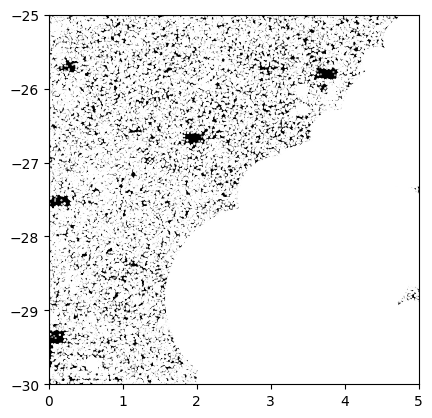

In [102]:
fig,ax = plt.subplots()
ax.set_facecolor('k')
for x,y,r in zip(ra,dec,radius):
    c = plt.Circle((x,y),r,color='white')
    ax.add_patch(c)

ax.set_xlim(0,5)
ax.set_ylim(-30,-25)
ax.set_aspect('equal')
plt.show()